In [1]:
import sys
import os
import cv2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from IPython.display import Image

import tensorflow as tf

from keras.utils import plot_model
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam #try different optimizers
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


In [2]:
import os
import numpy as np

from tqdm import tqdm_notebook, tnrange

from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [3]:
# Get and resize train images and masks
def get_data(path, train=True):
    #print(path)
    #print(os.walk(path + "images"))
    
    ids = next(os.walk(path + "img"))[2][1:]
    ids_mask = []
    if train == True:
        ids_mask = next(os.walk(path + "seg"))[2][1:]
    
    X = np.zeros((len(ids), im_height, im_width, 3), dtype=np.float32)
    print("shape")
    print(X[0].shape)
    if train == True:
        y = np.zeros((len(ids), im_height, im_width, 3), dtype=np.float32)
    print('Getting and resizing images ... ')
    for  n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
        print(n)
        # Load images
        img = load_img(path + '/img/' + id_)
        imgname = path + '/img/' + id_
        
        print(imgname)
        print(img.size)
        #x_img = img_to_array(img)
        x_img = np.array(img)
        #print(x_img)
        x_img = resize(x_img, (im_height, im_width, 3), mode='constant', preserve_range=True)

        # Load masks
        if train:
            id_mask = id_.split(".")[0] + '_seg_V1.tif'
            mask = img_to_array(load_img(path + '/seg/' + id_mask))
            mask = resize(mask, (im_height, im_width, 3), mode='constant', preserve_range=True)
            #print(mask)
            #print(mask.max)
         

        # Save images
        X[n] = x_img /255
        if train == True:
            y[n] = mask / 255

    print('Done!')
    if train:
        return X, y
    else:
        return X

In [4]:
# Set some parameters
im_width = 512 #696 to 672 too big the model does not train
im_height = 512 #520 to 512 too big
border = 5
path_train = "./image/train/"

In [5]:
ids = next(os.walk(path_train + "img"))[2][1:]
print(ids)
print(len(ids))
ids_mask = next(os.walk(path_train + "seg"))[2][1:]
print(ids_mask)
print(len(ids_mask))

['plan04911_0.tif', 'plan04911_1.tif', 'plan05673_0.tif', 'plan06807_0.tif', 'plan07082_0.tif', 'plan08116_0.tif', 'plan08135_0.tif', 'plan08135_1.tif', 'plan08153_0.tif', 'plan08197_0.tif', 'plan08197_1.tif', 'plan09226_0.tif', 'plan09226_1.tif', 'plan09514_0.tif', 'plan09514_1.tif', 'plan10191_0.tif', 'plan10212_0.tif', 'plan10212_1.tif', 'plan10598_0.tif', 'plan10711_0.tif', 'plan11011_0.tif', 'plan11013_0.tif', 'plan11013_1.tif', 'plan11140_0.tif', 'plan11412_0.tif', 'plan11453_0.tif', 'plan11453_1.tif', 'plan11465_0.tif', 'plan27244_0.tif', 'plan50048_0.tif', 'plan50048_1.tif', 'plan50048_2.tif', 'plan50068_0.tif', 'plan50068_1.tif', 'plan51009_0.tif', 'plan51009_1.tif', 'plan51019_0.tif', 'plan51019_1.tif', 'plan51059_0.tif', 'plan51059_1.tif', 'plan51129_0.tif', 'plan51214_0.tif', 'plan51239_0.tif', 'plan51239_1.tif', 'plan82003_0.tif', 'planDNC059034_0.tif', 'planDNC059034_1.tif', 'planDNC059035_0.tif', 'planDNC059035_1.tif', 'planDNC059035_2.tif', 'planDNC059037_0.tif', 'planD

In [7]:
X_train, y_train = get_data(path_train, train=True)

shape
(512, 512, 3)
Getting and resizing images ... 


<ipython-input-3-e8c5c46f6630>:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for  n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):


  0%|          | 0/56 [00:00<?, ?it/s]

0
./image/train//img/plan04911_0.tif
(999, 823)
1
./image/train//img/plan04911_1.tif
(1000, 869)
2
./image/train//img/plan05673_0.tif
(1000, 1119)
3
./image/train//img/plan06807_0.tif
(1000, 1113)
4
./image/train//img/plan07082_0.tif
(1000, 1053)
5
./image/train//img/plan08116_0.tif
(1000, 1024)
6
./image/train//img/plan08135_0.tif
(1000, 915)
7
./image/train//img/plan08135_1.tif
(1000, 957)
8
./image/train//img/plan08153_0.tif
(1000, 935)
9
./image/train//img/plan08197_0.tif
(1000, 1213)
10
./image/train//img/plan08197_1.tif
(1000, 990)
11
./image/train//img/plan09226_0.tif
(1000, 1052)
12
./image/train//img/plan09226_1.tif
(1000, 869)
13
./image/train//img/plan09514_0.tif
(1000, 1154)
14
./image/train//img/plan09514_1.tif
(1000, 1106)
15
./image/train//img/plan10191_0.tif
(1000, 762)
16
./image/train//img/plan10212_0.tif
(1000, 1107)
17
./image/train//img/plan10212_1.tif
(1000, 1136)
18
./image/train//img/plan10598_0.tif
(1000, 879)
19
./image/train//img/plan10711_0.tif
(1000, 1183)


In [8]:
print(X_train[0].shape)
print(len(X_train))
print(y_train[0].shape)
print(len(y_train))


(512, 512, 3)
56
(512, 512, 3)
56


In [9]:
fnX ='./npy files/X_train512_56imgs_noTextMag.npy'
fnY ='./npy files/y_train512_56imgs_noTextMag.npy'

np.save(fnX, X_train)
np.save(fnY, y_train)

In [10]:
fnX ='./npy files/X_train512_56imgs_noTextMag.npy'
fnY ='./npy files/y_train512_56imgs_noTextMag.npy'

X = np.load(fnX)
y = np.load(fnY)

data_train, data_val, masks_train, masks_val = train_test_split(X, y, test_size=0.20, random_state=42)

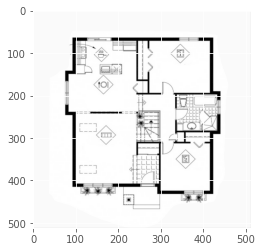

In [11]:
ix = random.randint(0, len(data_val))
image = data_val[ix]
imgplot = plt.imshow(image)
plt.show()

In [12]:
print(data_train[0].shape)
print(masks_train[0].shape)

(512, 512, 3)
(512, 512, 3)


23
hi


[None, None]

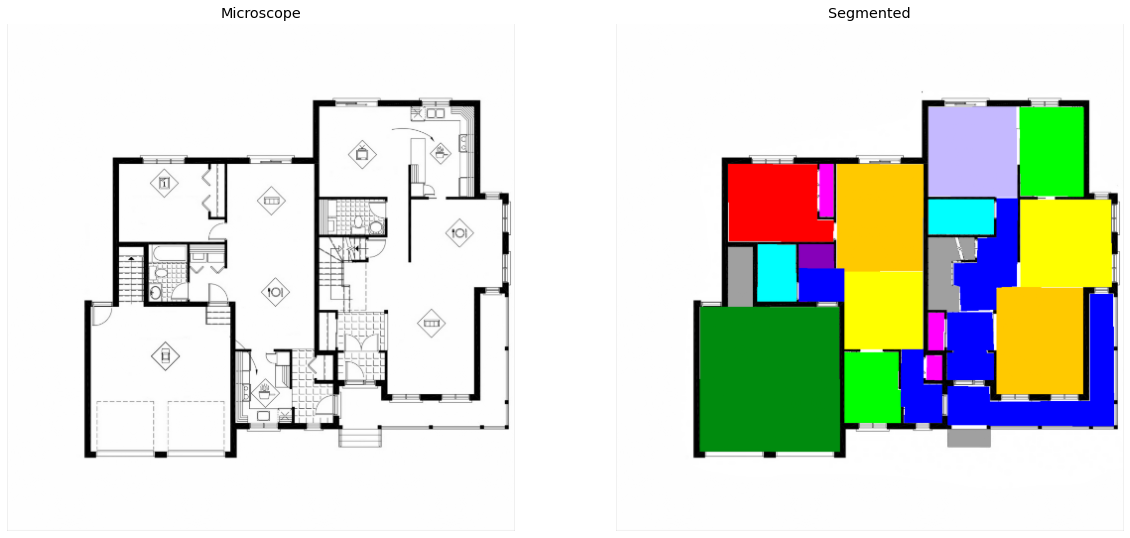

In [13]:
# Check if training data looks all right
#print(len(data_train))
#print(len(masks_train))
ix = random.randint(0,len(data_train)-1)
ix = 23
print(ix)
has_mask = masks_train[ix].max() > 0
#print(y_train[ix].max())
#print(y_train[ix])

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(data_train[ix])
if has_mask:
    print("hi")
    #ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Microscope')

ax[1].imshow(masks_train[ix])
ax[1].set_title('Segmented');
[axi.set_axis_off() for axi in ax.ravel()]

In [14]:
path_test = "./image/test 2/"
X_test = get_data(path_test, train=False)


shape
(512, 512, 3)
Getting and resizing images ... 


<ipython-input-3-e8c5c46f6630>:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for  n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):


  0%|          | 0/15 [00:00<?, ?it/s]

0
./image/test 2//img/plan06807_1.tif
(1000, 1001)
1
./image/test 2//img/plan07082_1.tif
(1000, 1024)
2
./image/test 2//img/plan10140_0.tif
(1000, 1290)
3
./image/test 2//img/plan10140_1.tif
(1000, 1114)
4
./image/test 2//img/plan11015_0.tif
(1000, 955)
5
./image/test 2//img/plan11018_1.tif
(1000, 1104)
6
./image/test 2//img/plan11347_0.tif
(1000, 1005)
7
./image/test 2//img/plan21233_1.tif
(1000, 801)
8
./image/test 2//img/plan21873_1.tif
(1000, 987)
9
./image/test 2//img/plan27234_0.tif
(1000, 967)
10
./image/test 2//img/plan27234_1.tif
(1000, 948)
11
./image/test 2//img/plan80014_1.tif
(1000, 1041)
12
./image/test 2//img/plan80124_0.tif
(1000, 1084)
13
./image/test 2//img/plan80124_1.tif
(1000, 1084)
14
./image/test 2//img/planDNC184007_0.tif
(1000, 1009)
Done!


In [15]:
print(len(X_test))

15


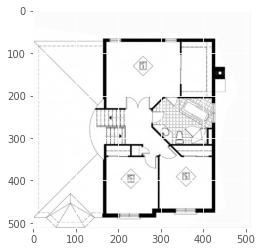

In [18]:
ix = random.randint(0, len(X_test)-1)
image = X_test[ix]
imgplot = plt.imshow(image)
plt.show()

In [17]:
fnX ='./npy files/X_test512_15imgs_noText.npy'


np.save(fnX, X_test)